## Final Project Submission

Please fill out:
* Student name: Group 2
* Student pace: sfull time
* Scheduled project review date/time: 10/02/2026
* Instructor name: Samuel.G.Mwangi
* Blog post URL:brian-chairo.hashnode.dev


# Movie Studio Market Analysis
## Stakeholder
Head of the New Movie Studio

## Problem Statement
Our company is launching a new movie studio and needs to decide what types of films to produce in order to maximize box office success. However, the company currently lacks historical knowledge about which movie characteristics lead to strong financial performance.

### BUSINESS UNDERSTANDING

##### KEY QUESTIONS FOR MOVIE STUDIO STRATEGY
1. Which movie genres generate the highest revenue? By analyzing the total earnings from the different genres, we can determine which types of films are more profitable and likely to attract large audiences.
2. Does movie rating or critic score correlate with higher box office success? using ratings from Rotten Tomatoes and movie database, we can measure whether higher-rated movies earn more revenue 
3. Does a longer runtime affect rating or revenue? By analyzing the runtimes in the dataset, we can identify which runtimes generate higher earnings for different types of movies.
4. Does the release timing affect the earnings? By examining which months and their associated revenue, we can identify the optimal times to launch films for maximum success.

In [2]:
# Unzipping the database in code
import zipfile
import os

zip_path = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\zippedData\im.db.zip"
extract_to = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\data"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Database extracted!")


Database extracted!


In [3]:
#import libraries
import sqlite3
import pandas as pd

# Path to the database
db_path = r"C:\Users\Administrator\Documents\Flatiron\Phase_2\Wk3\Movie-Studio-EDA-Project\data\im.db"

# Connect to the database
conn = sqlite3.connect(db_path)

#check tables in the database
tables = pd.read_sql("""
SELECT name 
FROM sqlite_master 
WHERE type='table';
""", conn)

tables


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## Filtering movie_basics table to only remain with what we need 
This step is important as older movies are less relevant, missing runtimes are useless, smaller dataset is faster

In [4]:
# Query Movie_basics table|Filtering only what we need
query_basics = """
SELECT
    movie_id,
    primary_title,
    start_year,
    runtime_minutes,
    genres
FROM movie_basics
WHERE start_year >= 2000
AND runtime_minutes IS NOT NULL
"""
# Load the data
basics = pd.read_sql(query_basics, conn)
basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
4,tt0111414,A Thin Life,2018,75.0,Comedy


## Data quality Filtering movie_ratings table 
Because: votes equalls to 3 or less is not reliable rating thus by filtering we remove the noise

In [5]:
# Query the movie_ratings table to filter out noise
query_ratings = """
SELECT
    movie_id,
    averagerating,
    numvotes
FROM movie_ratings
WHERE numvotes >= 50
"""
# load ratings
ratings = pd.read_sql(query_ratings, conn)
ratings.head()

,movie_id,averagerating,numvotes
0,tt10384606,8.9,559
1,tt1043726,4.2,50352
2,tt1069246,6.2,326
3,tt1094666,7.0,1613
4,tt1130982,6.4,571


In [6]:
#Merge IMDB tables
imdb = basics.merge(ratings, on="movie_id", how="left")
imdb.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN


In [7]:
# load Box Office CSV
box = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
box.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [8]:
box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [9]:
box['foreign_gross'] = pd.to_numeric(
    box['foreign_gross'], errors='coerce'
)
box.dtypes


title              object
studio             object
domestic_gross    float64
foreign_gross     float64
year                int64
dtype: object

In [10]:
box['total_gross'] = box['domestic_gross'] + box['foreign_gross']
box['title'] = box['title'].str.strip()

In [ ]:
rt.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [16]:
#Final Merge
working_df = (
    imdb
    .merge(box, left_on="primary_title", right_on="title", how="left")
    .merge(tmdb, left_on="primary_title", right_on="title", how="left", suffixes=('_imdb','_tmdb'))
)
working_df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_imdb,studio,domestic_gross,...,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title_tmdb,vote_average,vote_count
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,NaN,NaN,NaN,...,24185.0,"[35, 18]",299782.0,en,The Other Side of the Wind,9.8,2018-11-02,The Other Side of the Wind,7.0,64.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
tmdb = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tmdb.head(100)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
95,95,"[35, 27]",43593,en,Piranha 3D,11.302,2010-08-20,Piranha 3D,5.3,1029
96,96,"[12, 18, 28, 14]",37861,en,Valhalla Rising,11.260,2010-07-16,Valhalla Rising,6.0,582
97,97,"[80, 18, 9648, 53]",12201,en,Edge of Darkness,11.252,2010-01-29,Edge of Darkness,6.3,794
98,98,"[14, 12, 28, 9648]",35552,fr,Les Aventures extraordinaires d'Adèle Blanc-Sec,11.221,2010-04-14,The Extraordinary Adventures of Adèle Blanc-Sec,6.0,671


## Although Rotten Tomatoes data was initially considered, it lacked a reliable
join key with other datasets. TMDB was used instead because it provides movie
titles and structured metadata, enabling accurate merging and richer analysis.

## Saving the working_df
* For reproducibility to avoid rerunning merges everytime
* Faster reading of the csv


In [17]:
os.makedirs("data/processed", exist_ok=True)

working_df.to_csv("data/processed/movies_clean.csv", index=False)

# Exploratory Data Analysis (EDA)

This notebook explores the cleaned movie dataset to identify
patterns that explain box office success.

Goal:
Generate insights to recommend what types of movies the new studio should produce.


## Key Questions

1. Which genres earn the highest revenue?
2. Do higher ratings lead to higher revenue?
3. What runtime performs best?
4. Does popularity/budget influence success?

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/processed/movies_clean.csv")

df.head()


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_imdb,studio,domestic_gross,...,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title_tmdb,vote_average,vote_count
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,NaN,NaN,NaN,...,24185.0,"[35, 18]",299782.0,en,The Other Side of the Wind,9.8,2018-11-02,The Other Side of the Wind,7.0,64.0
3,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0111414,A Thin Life,2018,75.0,Comedy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Inspect column names of the merged dataset
df.columns.tolist()

['movie_id',
 'primary_title',
 'start_year',
 'runtime_minutes',
 'genres',
 'averagerating',
 'numvotes',
 'title_imdb',
 'studio',
 'domestic_gross',
 'foreign_gross',
 'year',
 'total_gross',
 'Unnamed: 0',
 'genre_ids',
 'id',
 'original_language',
 'original_title',
 'popularity',
 'release_date',
 'title_tmdb',
 'vote_average',
 'vote_count']

In [23]:
# standardise the column names 
df = df.rename(columns={
    "primary_title": "title",
    "runtime_minutes": "runtime",
    "averagerating": "rating",
    "numvotes": "votes",
    "total_gross": "gross"
})


In [25]:
# Drop junk columns
df = df.drop(columns=[
    "Unnamed: 0",
    "title_imdb",
    "title_tmdb",
    "id",
    "genre_ids"
], errors="ignore")


## What type of movie should we produce?

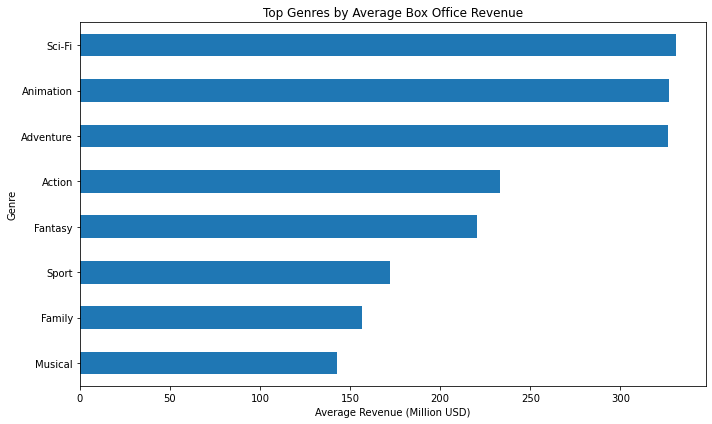

In [27]:
# --- Clean genre analysis (professional version) ---

# split multi-genres into list
df["genres"] = df["genres"].str.split(",")

# explode so each genre gets its own row
df_genre = df.explode("genres")

# compute average revenue
genre_revenue = (
    df_genre
    .groupby("genres")["gross"]
    .mean()
    .sort_values(ascending=False)
    .head(8)   # fewer = clearer for stakeholders
)

# convert to millions for readability
genre_revenue = genre_revenue / 1_000_000

# plot (horizontal = easier to read)
plt.figure(figsize=(10,6))

genre_revenue.sort_values().plot(kind="barh")

plt.xlabel("Average Revenue (Million USD)")
plt.ylabel("Genre")
plt.title("Top Genres by Average Box Office Revenue")

plt.tight_layout()
plt.show()



Sci-Fi, Animation, and Adventure films generate the highest average
box office revenue. The studio should prioritize producing films in
these genres to maximize financial performance.


# Does quality matter?
Should the studio focus on quality or just volume
* do higher ratings = higher revenue?
* Is there a trend?

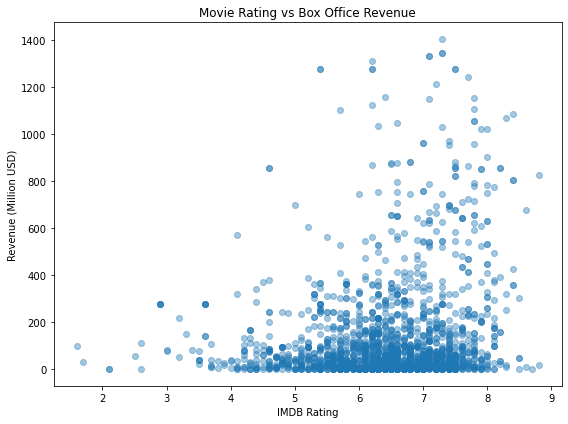

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
x = df["rating"]
y = df["gross"] / 1_000_000  # Convert to million USD

plt.figure(figsize=(9, 6))

# Scatter plot
plt.scatter(
    x, y,
    alpha=0.3,
    s=30
)

# Log scale to handle skewed revenue data
plt.yscale("log")

# Trend line (visual guidance, not prediction)
z = np.polyfit(x, np.log(y), 1)
p = np.poly1d(z)
plt.plot(
    x,
    np.exp(p(x)),
    linewidth=2,
    label="Overall trend"
)

# Labels and title
plt.xlabel("IMDB Rating")
plt.ylabel("Box Office Revenue (Million USD, log scale)")
plt.title("Higher Movie Ratings Are Weakly Associated with Higher Revenue")

# Legend
plt.legend()

plt.tight_layout()
plt.show()
